In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
np.random.seed(42)

# Week 11: Clustering Analysis in Python

- Section 401
- Nov 13, 2023

## Clustering in Python

- Both spatial and non-spatial datasets
- Two new techniques: 
    - Non-spatial: **K-means**
    - Spatial: **DBSCAN**
- Two labs/exercises this week:
    1. Grouping Philadelphia neighborhoods by AirBnb listings
    1. Identifying clusters in taxi rides in NYC

## "Machine learning" and "AI"

![](imgs/machine_learning.jpg)

- The computer **learns** patterns and properties of an input data set without the user specifying them beforehand
- Can be both **supervised** and **unsupervised**

### Supervised
- Example: classification
- Given a training set of **labeled** data, learn to assign labels to new data

### Unsupervised
- Example: clustering
- Identify structure / clusters in data without any prior knowledge

## Machine learning in Python: scikit-learn

- State-of-the-art machine learning in Python
- Easy to use, lots of functionality

## Clustering is just one (of many) features

![](imgs/scikit_learn.png)

[https://scikit-learn.org/stable/](https://scikit-learn.org/stable/)


::: {.callout-note}
We will focus on clustering algorithms today and discuss a few other machine learning techniques in the next two weeks. If there is a specific scikit-learn use case we won't cover, I'm open to ideas for incorporating it as part of the final project. 

:::

## Part 1: Non-spatial clustering

**The goal**

Partition a dataset into groups that have a similar set of attributes, **or features**, within the group and a dissimilar set of features between groups.

Minimize the *intra-cluster* variance and maximize the *inter-cluster* variance of features.

### Some intuition

![](imgs/clustering.png)

### K-Means clustering

- Simple but robust clustering algorithm
- Widely used
- **Important:** user must specify the number of clusters
- **Cannot** be used to find density-based clusters

### This is just one of several clustering methods

[https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods](https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods)

::: {.callout-tip}
### A good introduction

Check out [Andrew Ng's Coursera lecture](https://www.youtube.com/watch?v=0D4LnsJr85Y) on unsupervised clustering.

:::

### How does it work?

**Minimizes the intra-cluster variance**: minimizes the sum of the squared distances between all points in a cluster and the cluster centroid

### K-means in action

![](imgs/K-means_convergence.gif)

### Example: Clustering countries by health and income

- Health expectancy in years vs. GDP per capita and population for 187 countries (as of 2015)
- Data from [Gapminder](https://www.gapminder.org/data/)

In [2]:
import altair as alt
from vega_datasets import data as vega_data
import pandas as pd

Read the data from a URL:

In [3]:
gapminder = pd.read_csv(vega_data.gapminder_health_income.url)
gapminder.head()

,country,income,health,population
0,Afghanistan,1925,57.63,32526562
1,Albania,10620,76.00,2896679
2,Algeria,13434,76.50,39666519
3,Andorra,46577,84.10,70473
4,Angola,7615,61.00,25021974


Plot it with altair:

In [4]:
(
    alt.Chart(gapminder)
    .mark_circle()
    .encode(
        alt.X("income:Q", scale=alt.Scale(type="log")),
        alt.Y("health:Q", scale=alt.Scale(zero=False)),
        size="population:Q",
        tooltip=list(gapminder.columns),
    )
    .properties(width=800, height=600)
    .interactive()
)

alt.Chart(...)

#### K-Means with scikit-learn

In [5]:
from sklearn.cluster import KMeans

Let's start with 5 clusters

In [6]:
KMeans?

Init signature:
KMeans(
    n_clusters=8,
    *,
    init='k-means++',
    n_init='warn',
    max_iter=300,
    tol=0.0001,
    verbose=0,
    random_state=None,
    copy_x=True,
    algorithm='lloyd',
)
Docstring:     
K-Means clustering.

Read more in the :ref:`User Guide <k_means>`.

Parameters
----------

n_clusters : int, default=8
    The number of clusters to form as well as the number of
    centroids to generate.

init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
    Method for initialization:

    'k-means++' : selects initial cluster centroids using sampling based on
    an empirical probability distribution of the points' contribution to the
    overall inertia. This technique speeds up convergence. The algorithm
    implemented is "greedy k-means++". It differs from the vanilla k-means++
    by making several trials at each sampling step and choosing the best centroid
    among them.

    'random': cho

In [7]:
kmeans = KMeans(n_clusters=5, n_init=10, random_state = 42)

Lot's of optional parameters, but `n_clusters` is the most important:

#### Let's fit just income first

Use the `fit()` function

In [8]:
kmeans.fit(gapminder[['income']]);

#### Extract the cluster labels

Use the `labels_` attribute

In [9]:
gapminder['label'] = kmeans.labels_

#### How big are our clusters?

In [10]:
gapminder.groupby('label').size()

label
0    106
1      6
2     50
3      1
4     24
dtype: int64

#### Plot it again, coloring by our labels

In [11]:
(
    alt.Chart(gapminder)
    .mark_circle()
    .encode(
        alt.X("income:Q", scale=alt.Scale(type="log")),
        alt.Y("health:Q", scale=alt.Scale(zero=False)),
        size="population:Q",
        color=alt.Color("label:N", scale=alt.Scale(scheme="dark2")),
        tooltip=list(gapminder.columns),
    )
    .properties(width=800, height=600)
    .interactive()
)

alt.Chart(...)

#### Calculate average income by group

In [12]:
gapminder.groupby("label")['income'].mean().sort_values()

label
0      5279.830189
2     21040.820000
4     42835.500000
1     74966.166667
3    132877.000000
Name: income, dtype: float64

Data is nicely partitioned into income levels

#### How about health, income, and population?

In [13]:
# Fit all three columns
kmeans.fit(gapminder[['income', 'health', 'population']])

# Extract the labels
gapminder['label'] = kmeans.labels_

In [14]:
gapminder

,country,income,health,population,label
0,Afghanistan,1925,57.63,32526562,0
1,Albania,10620,76.00,2896679,0
2,Algeria,13434,76.50,39666519,3
3,Andorra,46577,84.10,70473,0
4,Angola,7615,61.00,25021974,0
...,...,...,...,...,...
182,Vietnam,5623,76.50,93447601,3
183,West Bank and Gaza,4319,75.20,4668466,0
184,Yemen,3887,67.60,26832215,0
185,Zambia,4034,58.96,16211767,0


In [15]:
(
    alt.Chart(gapminder)
    .mark_circle()
    .encode(
        alt.X("income:Q", scale=alt.Scale(type="log")),
        alt.Y("health:Q", scale=alt.Scale(zero=False)),
        size="population:Q",
        color=alt.Color("label:N", scale=alt.Scale(scheme="dark2")),
        tooltip=list(gapminder.columns),
    )
    .properties(width=800, height=600)
    .interactive()
)

alt.Chart(...)

#### It....didn't work that well

What's wrong?

**K-means is distance-based, but our features have wildly different distance scales**

#### scikit-learn to the rescue: pre-processing

* Scikit-learn has a utility to normalize features with an average of zero and a variance of 1
* Use the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class

In [16]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
StandardScaler?
#if you know your data is normally distributed

Init signature: StandardScaler(*, copy=True, with_mean=True, with_std=True)
Docstring:     
Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample `x` is calculated as:

    z = (x - u) / s

where `u` is the mean of the training samples or zero if `with_mean=False`,
and `s` is the standard deviation of the training samples or one if
`with_std=False`.

Centering and scaling happen independently on each feature by computing
the relevant statistics on the samples in the training set. Mean and
standard deviation are then stored to be used on later data using
:meth:`transform`.

Standardization of a dataset is a common requirement for many
machine learning estimators: they might behave badly if the
individual features do not more or less look like standard normally
distributed data (e.g. Gaussian with 0 mean and unit variance).

For instance many elements used in the objective function of
a learning algorithm (such as the RBF kernel of Suppor

In [19]:
scaler = StandardScaler()

#### Use the `fit_transform()` function to scale your features

In [20]:
gapminder_scaled = scaler.fit_transform(gapminder[['income', 'health', 'population']])

**Important**: The `fit_transform()` function converts the DataFrame to a numpy array:

gapminder_scared_df  = pd.Dataframe(

In [21]:
# fit_transform() converts the data into a numpy array
gapminder_scaled[:5]

array([[-0.79481258, -1.8171424 , -0.04592039],
       [-0.34333373,  0.55986273, -0.25325837],
       [-0.1972197 ,  0.62456075,  0.00404216],
       [ 1.52369617,  1.6079706 , -0.27303503],
       [-0.49936524, -1.38107777, -0.09843447]])

In [22]:
# mean of zero
gapminder_scaled.mean(axis=0)

array([ 8.07434927e-17, -1.70511258e-15, -1.89984689e-17])

In [23]:
# variance of one
gapminder_scaled.std(axis=0)

array([1., 1., 1.])

#### Now fit the scaled features

In [24]:
# Perform the fit
kmeans.fit(gapminder_scaled)

# Extract the labels
gapminder['label'] = kmeans.labels_

In [25]:
(
    alt.Chart(gapminder)
    .mark_circle()
    .encode(
        alt.X("income:Q", scale=alt.Scale(type="log")),
        alt.Y("health:Q", scale=alt.Scale(zero=False)),
        size="population:Q",
        color=alt.Color("label:N", scale=alt.Scale(scheme="dark2")),
        tooltip=list(gapminder.columns),
    )
    .properties(width=800, height=600)
    .interactive()
)

alt.Chart(...)

In [26]:
# Number of countries per cluster
gapminder.groupby("label").size()

label
0    85
1    62
2     2
3    33
4     5
dtype: int64

In [27]:
# Average population per cluster
gapminder.groupby("label")['population'].mean().sort_values() / 1e6

label
4       2.544302
1      21.191274
0      26.478761
3      31.674060
2    1343.549735
Name: population, dtype: float64

In [28]:
# Average life expectancy per cluster
gapminder.groupby("label")['health'].mean().sort_values()

label
1    62.342097
2    71.850000
0    74.376353
3    80.830303
4    80.920000
Name: health, dtype: float64

In [29]:
# Average income per cluster
gapminder.groupby("label")['income'].mean().sort_values() / 1e3

label
1     4.136016
2     9.618500
0    13.347376
3    41.048818
4    91.524200
Name: income, dtype: float64

In [30]:
gapminder.loc[gapminder['label']==4]

,country,income,health,population,label
24,Brunei,73003,78.7,423188,4
88,Kuwait,82633,80.7,3892115,4
97,Luxembourg,88314,81.1,567110,4
134,Qatar,132877,82.0,2235355,4
145,Singapore,80794,82.1,5603740,4


In [31]:
kmeans.inertia_

80.72009578392846

In [32]:
gapminder.loc[gapminder['label']==4]

,country,income,health,population,label
24,Brunei,73003,78.7,423188,4
88,Kuwait,82633,80.7,3892115,4
97,Luxembourg,88314,81.1,567110,4
134,Qatar,132877,82.0,2235355,4
145,Singapore,80794,82.1,5603740,4


### Exercise: Clustering neighborhoods by Airbnb stats

I've extracted neighborhood Airbnb statistics for Philadelphia neighborhoods from [Tom Slee's website](http://tomslee.net/airbnb-data).

The data includes average price per person, overall satisfaction, and number of listings.

::: {.callout-note}
### Two good references for Airbnb data

- [Tom Slee's website](http://tomslee.net/airbnb-data)
- [Inside Airbnb](http://insideairbnb.com/get-the-data.html)

Original research study: [How Airbnb's Data Hid the Facts in New York City](http://insideairbnb.com/reports/how-airbnbs-data-hid-the-facts-in-new-york-city.pdf)

:::

#### Step 1: Load the data with pandas

The data is available in CSV format ("philly_airbnb_by_neighborhoods.csv") in the "data/" folder of the repository.

In [54]:
data = pd.read_csv("./data/philly_airbnb_by_neighborhoods.csv")

In [55]:
data.head()

,neighborhood,price_per_person,overall_satisfaction,N
0,ALLEGHENY_WEST,120.791667,4.666667,23
1,BELLA_VISTA,87.407920,3.158333,204
2,BELMONT,69.425000,3.250000,11
3,BREWERYTOWN,71.788188,1.943182,142
4,BUSTLETON,55.833333,1.250000,19


#### Step 2: Perform the K-Means fit

- Use our three features: `price_per_person`, `overall_satisfaction`, `N`
- I used 5 clusters, but you are welcome to experiment with different values! We will discuss what the *optimal* number is after we go through the solutions!
- Scaling the features is recommended, but if the scales aren't too different, so probably isn't necessary in this case

In [56]:
data_scaled = scaler.fit_transform(data[['price_per_person', 'overall_satisfaction', 'N']])

In [57]:
kmeans.fit(data_scaled)

KMeans(n_clusters=5, n_init=10, random_state=42)

In [58]:
data["label"] = kmeans.labels_
data.head()

,neighborhood,price_per_person,overall_satisfaction,N,label
0,ALLEGHENY_WEST,120.791667,4.666667,23,0
1,BELLA_VISTA,87.407920,3.158333,204,0
2,BELMONT,69.425000,3.250000,11,0
3,BREWERYTOWN,71.788188,1.943182,142,0
4,BUSTLETON,55.833333,1.250000,19,1


#### Step 3: Calculate average features per cluster

To gain some insight into our clusters, after calculating the K-Means labels:
- group by the `label` column
- calculate the `mean()` of each of our features
- calculate the number of neighborhoods per cluster

In [60]:
grouped = data.groupby("label", as_index = False)[
    ["price_per_person","overall_satisfaction","N"]
].mean().sort_values("price_per_person")

In [61]:
grouped_neighborhood = data.groupby("label",as_index = False)["neighborhood"].count().sort_values("label")

In [62]:
grouped.head()

,label,price_per_person,overall_satisfaction,N
0,0,73.199020,3.137213,76.550725
1,1,79.250011,0.697461,23.473684
4,4,116.601261,2.936508,389.933333
3,3,136.263996,3.000924,1499.000000
2,2,387.626984,5.000000,31.000000


In [63]:
grouped_neighborhood.head()

,label,neighborhood
0,0,69
1,1,19
2,2,1
3,3,1
4,4,15


#### Step 4: Plot a choropleth, coloring neighborhoods by their cluster label

- Part 1: Load the Philadelphia neighborhoods available in the data directory:  
    - `./data/philly_neighborhoods.geojson`
- Part 2: Merge the Airbnb data (with labels) and the neighborhood polygons
- Part 3: Use geopandas to plot the neighborhoods
    - The `categorical=True` and `legend=True` keywords will be useful here

In [64]:
import geopandas as gpd

In [65]:
gpd_df = gpd.read_file("./data/philly_neighborhoods.geojson")

In [66]:
gpd_df.head()

,Name,geometry
0,LAWNDALE,"POLYGON ((-75.08616 40.05013, -75.08893 40.044..."
1,ASTON_WOODBRIDGE,"POLYGON ((-75.00860 40.05369, -75.00861 40.053..."
2,CARROLL_PARK,"POLYGON ((-75.22673 39.97720, -75.22022 39.974..."
3,CHESTNUT_HILL,"POLYGON ((-75.21278 40.08637, -75.21272 40.086..."
4,BURNHOLME,"POLYGON ((-75.08768 40.06861, -75.08758 40.068..."


In [69]:
gpd_df = gpd_df.to_crs(epsg = 3857)

In [71]:
merged_df = gpd_df.merge(
    data,
    left_on = ["Name"],
    right_on = ["neighborhood"],
    how = "left",
    
)
merged_df.head()

,Name,geometry,neighborhood,price_per_person,overall_satisfaction,N,label
0,LAWNDALE,"POLYGON ((-8358553.055 4873230.294, -8358860.9...",LAWNDALE,42.344444,0.500000,19.0,1.0
1,ASTON_WOODBRIDGE,"POLYGON ((-8349918.619 4873747.027, -8349919.6...",NaN,NaN,NaN,NaN,NaN
2,CARROLL_PARK,"POLYGON ((-8374201.334 4862630.181, -8373476.5...",NaN,NaN,NaN,NaN,NaN
3,CHESTNUT_HILL,"POLYGON ((-8372648.096 4878500.900, -8372641.9...",CHESTNUT_HILL,69.123478,3.444444,74.0,0.0
4,BURNHOLME,"POLYGON ((-8358721.906 4875917.696, -8358711.5...",NaN,NaN,NaN,NaN,NaN


In [72]:
#assign -1 to the neighbrhood without any listings
merged_df["label"] = merged_df["label"].fillna(-1)

In [74]:
merged_df.head()

,Name,geometry,neighborhood,price_per_person,overall_satisfaction,N,label
0,LAWNDALE,"POLYGON ((-8358553.055 4873230.294, -8358860.9...",LAWNDALE,42.344444,0.500000,19.0,1.0
1,ASTON_WOODBRIDGE,"POLYGON ((-8349918.619 4873747.027, -8349919.6...",NaN,NaN,NaN,NaN,-1.0
2,CARROLL_PARK,"POLYGON ((-8374201.334 4862630.181, -8373476.5...",NaN,NaN,NaN,NaN,-1.0
3,CHESTNUT_HILL,"POLYGON ((-8372648.096 4878500.900, -8372641.9...",CHESTNUT_HILL,69.123478,3.444444,74.0,0.0
4,BURNHOLME,"POLYGON ((-8358721.906 4875917.696, -8358711.5...",NaN,NaN,NaN,NaN,-1.0


In [75]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, "Map for neighborhood's label")

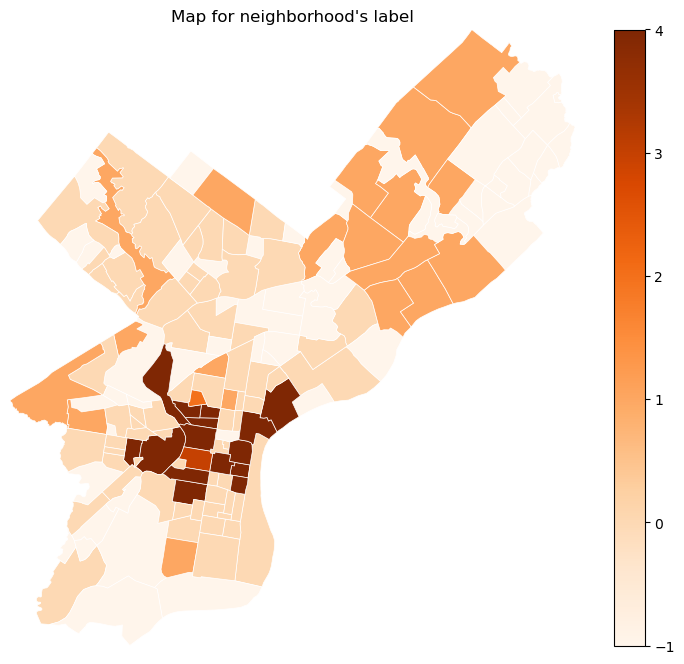

In [89]:
fig, ax = plt.subplots(figsize = (10,8))

merged_df.plot(
    ax =ax, 
    column = "label",
    edgecolor = "white",
    linewidth = 0.5,
    legend = True, 
    cmap = "Oranges",
)

#Format
# NEW: Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = merged_df.total_bounds

# NEW: Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Map for neighborhood's label")

In [ ]:
# some usual colormaps:
#     plot_color_gradients('Perceptually Uniform Sequential',
#                      ['viridis', 'plasma', 'inferno', 'magma', 'cividis'])

#### Step 5: Plot an interactive map

Use hvplot / geopandas to plot the clustering results with a tooltip for neighborhood name and tooltip.

#### Based on these results, where would you want to stay?




In [80]:
import geopandas as gpd
import hvplot.pandas

In [88]:
# Pass arguments directly to hvplot()
# and it recognizes polygons automatically
merged_df.hvplot(
    c="label",
    frame_width=600,
    frame_height=600,
    geo=True,
    crs=3857,
    cmap="Magma",
    hover_cols=["Name"],
)

/Users/cjingyi/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/cjingyi/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/cjingyi/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


:Polygons   [Longitude,Latitude]   (label,Name)

In [107]:
merged_df.explore(
    column="label",
    categorical = True,
    legend = True,
    tiles = "cartodb positron",
    cmap="Dark2",
)

### Why 5 groups? 

Use the ["Elbow" method](https://en.wikipedia.org/wiki/Elbow_method_(clustering))...

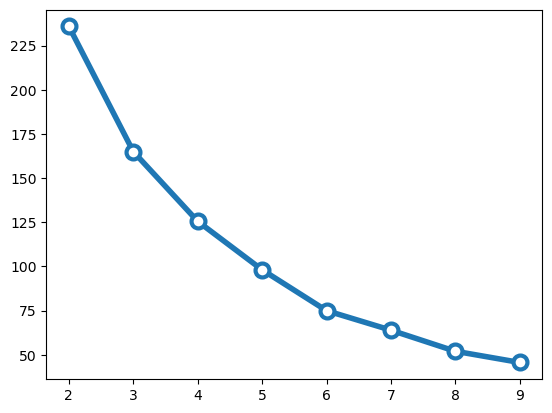

In [108]:
# Number of clusters to try out
n_clusters = list(range(2, 10))

# Run kmeans for each value of k
inertias = []
for k in n_clusters:
    
    # Initialize and run
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(data_scaled)
    
    # Save the "inertia"
    inertias.append(kmeans.inertia_)
    
# Plot it!
plt.plot(n_clusters, inertias, marker='o', ms=10, mfc='white', lw=4, mew=3);

### The `kneed` package

There is also a nice package called kneed that can determine the “knee” point quantitatively, using the [kneedle algorithm](https://raghavan.usc.edu/papers/kneedle-simplex11.pdf).

In [109]:
n_clusters

[2, 3, 4, 5, 6, 7, 8, 9]

In [110]:
from kneed import KneeLocator

# Initialize the knee algorithm
kn = KneeLocator(n_clusters, inertias, curve='convex', direction='decreasing')

# Print out the knee 
print(kn.knee)

5


## That's it!

More clustering on Wednesday!